In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
import time
import pickle

In [11]:
from transformers import RobertaTokenizer, RobertaModel
import torch
import pickle

model_name = 'SamLowe/roberta-base-go_emotions'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model  = RobertaModel.from_pretrained(model_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [4]:
# 파일 로드
# df = pd.read_csv('/content/gdrive/MyDrive/team project2/merged_last.csv')
df = pd.read_csv('/content/drive/MyDrive/집교 2_Team P/merged_last_31110.csv')

# 'track_id'와 'text' 열만 추출
df = df[['track_id', 'text']]

# 필터링된 데이터 확인
print(df.shape)
print(df.head())

(31110, 2)
   track_id                                               text
0         2  Welcome to our fortress tall  \nTake some time...
1         8  This morning I made the call  \nThe one that e...
2      1524  Madness comes, and madness goes  \nAn insane p...
3      1785  I like the way that I make you itch  \nAnd all...
4      1787  Forgotten things remembered  \nThe tigers eat ...


In [16]:
# 텍스트 전처리 및 임베딩 추출 함수
def get_embeddings_mean(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

def get_embeddings_cls(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()


In [17]:
import time

start_time = time.time()

# 각 텍스트의 임베딩 추출
# df['embedding_mean'] = df['text'].apply(get_embeddings_mean)
df['embedding_cls'] = df['text'].apply(get_embeddings_cls)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time} seconds")

# 결과 출력
print(df[['track_id', 'embedding_mean']])


Elapsed Time: 836.1054449081421 seconds


KeyError: ignored

In [18]:
print(df[['track_id', 'embedding_cls']])

       track_id                                      embedding_cls
0             2  [-0.43970472, 0.17358445, 0.52987283, 0.215904...
1             8  [-0.9121488, -0.5041361, -0.64265925, 0.889575...
2          1524  [-0.35779256, -0.21245627, -0.43505853, 1.2747...
3          1785  [-0.51160103, 0.51571244, 0.46193764, -0.37046...
4          1787  [-1.1975518, 0.555055, -0.049067017, 0.4179305...
...         ...                                                ...
31105  13430827  [-0.31775776, 0.057838887, 0.6800215, 0.219710...
31106  13430837  [-0.43450806, 0.21885245, -0.58856773, 0.45622...
31107  13430948  [-0.94596916, -0.18220451, 0.6059976, 0.357769...
31108  13430963  [-0.96914256, -0.17204548, -0.59271777, 1.2157...
31109  13430969  [-0.50357866, -0.38152727, 0.24538858, 0.78810...

[31110 rows x 2 columns]


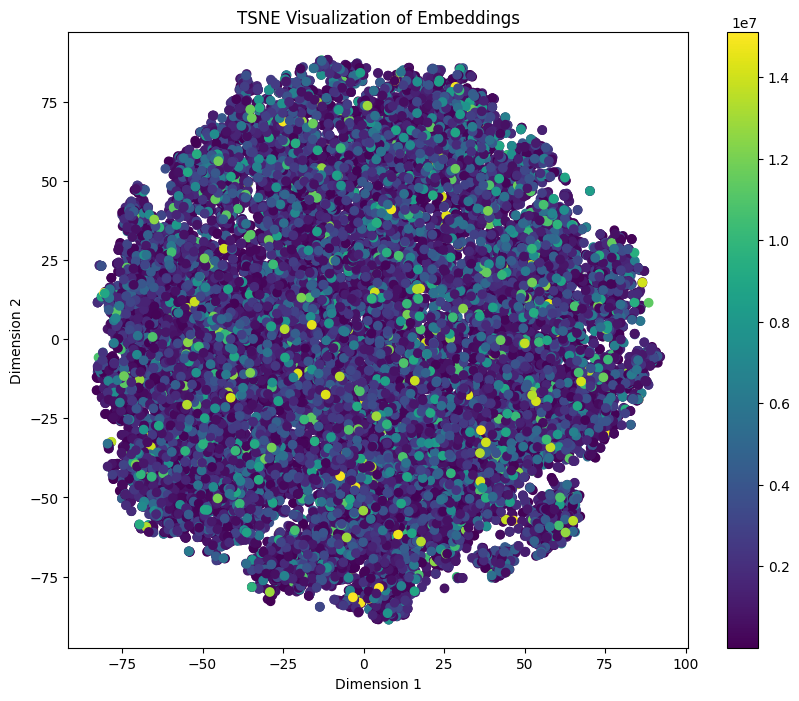

In [26]:
from sklearn.manifold import TSNE

# Convert 'embedding_cls' column to a 2D NumPy array
embedding_array = np.array(df['embedding_cls'].tolist())

# TSNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(embedding_array)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=df['track_id'], cmap='viridis')
plt.title('TSNE Visualization of Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()